[Open this notebook on Colab](https://colab.research.google.com/github/probabll/ntmi-tutorials/blob/main/T3.ipynb)

# Guide

* Check the entire notebook before you get started, this gives you an idea of what lies ahead.
* Note that, as always, the notebook recaps some theory, and contains solved exercises. While you should probably make use of this theory recap, be careful not to spend disproportionately more time on this than you should. The theory here is more condensed, and should be easier to understand after week 3's reading and after the highlights discussed in class (HC3a).
* There are various excerpts of code that should be studied so that you can adapt them in graded exercises.

## ILOs

After completing this lab you should be able to

* develop generalised linear models of text classification and text regression in Python using sklearn and jax
* estimate parameters via gradient-based optimisation

**General notes**

* In this notebook you are expected to use $\LaTeX$.
* Use python3


## Table of Contents




### Topics

* [Setting up](#sec:Setting_up)
* [Generalised Linear Models (GLMs)](#sec:Generalised_Linear_Models_(GLMs))
* [Parameter estimation](#sec:Parameter_estimation)
* [Implementation](#sec:Implementation)
	* [Binary classifier](#sec:Binary_classifier)
	* [Baseline: NBC on Features](#sec:Baseline:_NBC_on_Features)
	* [Bernoulli GLM on Jax](#sec:Bernoulli_GLM_on_Jax)
* [Python/JAX GLM Class](#sec:Python/JAX_GLM_Class)
	* [Binary classification experiment](#sec:Binary_classification_experiment)
	* [Ordinal regression experiment](#sec:Ordinal_regression_experiment)


### Table of ungraded exercises

1. [Space and time complexity of the linear model](#ungraded-1)
1. [Analysing the loss for the Bernoulli GLM](#ungraded-2)
1. [GLM class](#ungraded-3)
1. [Code for parameter estimation](#ungraded-4)
1. [Change the feature function](#ungraded-5)
1. [Further analysis](#ungraded-6)


### Table of graded exercises

*Important:* The grader may re-run your notebook to investigate its correctness, but you must upload your notebook with the cells already run and make sure that all your answers are visible without the need to re-run the notebook.


Exercises have equal weights.


1. [Subjectivity classifier](#graded-1)
1. [Poisson regression](#graded-2)

<a name='sec:Setting_up'></a>
# Setting up

Make sure you have colab configure to use 4 spaces for TAB (Tools/Settings/Editor/Indentation). If you change your Runtime to GPU (Runtime/Change runtime type) model training will be faster, but for this tutorial a GPU is not strictly necessary.

In [6]:
!pip install numpy
!pip install jax
!pip install sklearn
!pip install pandas
!pip install seaborn
!pip install tabulate

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [7]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(font_scale=1.3)

import jax
from jax import device_put

import json
import gzip
import urllib.request

from tabulate import tabulate

import sklearn
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, mean_absolute_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

import nltk

nltk.download('punkt')
nltk.download('sentence_polarity')
nltk.download('subjectivity')
nltk.download('brown')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package sentence_polarity to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping corpora/sentence_polarity.zip.
[nltk_data] Downloading package subjectivity to /root/nltk_data...
[nltk_data]   Unzipping corpora/subjectivity.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

<a name='sec:Generalised_Linear_Models_(GLMs)'></a>
# Generalised Linear Models (GLMs)

GLMs are used to prescribe conditional distributions of the kind $P_{Y|X=x}$. In our application domain, $x \in \mathcal X$ is typically one or more pieces of text, and $y \in \mathcal Y$ can be nominal or numerical.
    
In a nutshell, a GLM maps $x$ to the parameter of our choice of pmf (or pdf) for the distribution $P_{Y|X=x}$. It does so via a parametric function $g(x; \boldsymbol\theta)$ with trainable parameters $\boldsymbol\theta$. This function involves:
* a predefined feature function $\mathbf h(x)$, which maps $x$ to a $D$-dimensional vector of numerical features;
* a linear transformation of this vector (here is where the trainable parameters $\boldsymbol \theta$ play a role), whose result we refer to as the linear predictor;
* and, depending on the pmf/pdf we choose, a non-linear activation function that constrains the so-called linear predictor to the space of values that is coherent with our choice of pmf/pdf.
    
    
To build GLMs:
    
1. Start with choosing  the family you will model with. This depends on the type of data you have (e.g., binary means Bernoulli, $K$-way classification usually means Categorical, ordinal regression usually means Poisson, but it could be some other distribution over natural numbers or a subset thereof, like the Binomial, continuous regression might require a Normal distribution, regressing to vectors of proportions might require a Dirichlet distribution, etc.). You don't need to know all these distributions by heart, when needed, we will give you information about them that will help you judge their relevance in context.

2. The input is text, but GLMs operate with inputs in the real coordinate space, so you need a vector-valued feature function $\mathbf h(x)$. Define your feature function. Common choices are based on ideas such as bag-of-words and tf-idf.

3. In a GLM, the input $\mathbf h(x)$ and the parameters $\boldsymbol\theta$ interact linearly. This constrains us to either operations like dot product, matrix multiplication and scalar or vector addition. Whether we have "dot product plus scalar" or "matrix multiplication plus vector" depends exclusively on the dimensionality we need for the linear predictor. If we need a single scalar, we wil use the former. If we need a vector, we will use the latter.

4. Example 1: the Poisson parameter is a single scalar, thus we know that we need to map from $\mathbf h(x)$ to a single scalar, as we achieve with "dot product plus scalar". Example 2: the Categorical parameter is a vector, thus we know that we need to map from $\mathbf h(x)$ to a $K$-dimensional vector, as we achieve with "matrix multiplication plus vector". Example 3: the Normal distribution has 2 parameters, a location and a scale, thus we use two linear transformations of the kind 'dot product plus scalar', one for each parameter.

5. Finally, the statistical parameter is generally constrained to a subset of the real numbers, so we need an activation function that constrains the linear predictor accordingly. Example 1: the Poisson parameter is *strictly positive* by definition, so we need to wrap the linear function around something whose output is *never negative* and *never 0*, no matter which real-valued input we give it. The exponential function does that for us. There are other activation functions that achieve the same result, but the exponential is convenient for certain reasons (e.g., it's logarithm is linear). In our implementation below we will see other options. Example 2: the Categorical parameter must be a probability vector, the softmax function can realise that constraint for us. Example 3: the Normal location is unconstrained, we don't need an activation for it (or, equivalently, we use the 'identity function' which simply returns the linear predictor without any change), the scale however is constrained to being strictly positive, for that we can for example exponentiate the linear predictor.



<a name='sec:Parameter_estimation'></a>
# Parameter estimation

Given a training set $\mathcal D = \{(x^{(n)}, y^{(n)})\}_{n=1}^N$ of $N$ observed input-target pairs we would ideally choose the parameter vector $\boldsymbol\theta$ that maximises the log-likelihood of the model. Let $f(y; \phi=g(x;\boldsymbol\theta))$ denote the pmf (or pdf) that prescribes the cpd $P_{Y|X=x}$, then:

\begin{align}
\mathcal L_{\mathcal D}(\boldsymbol\theta) &= \sum_{n=1}^N \log f(y^{(n)}; \phi_n) \quad \text{where } \phi_n = g(x^{(n)}; \boldsymbol\theta)\\
\boldsymbol\theta^\star &= \arg\max_{\boldsymbol\theta}~\mathcal L_{\mathcal D}(\boldsymbol\theta)
\end{align}

Unlike tabular CPDs, there is no simple expression for the MLE of a GLM. But, we can employ a gradient-based search. This search uses the gradient $\nabla_{\boldsymbol \theta}\mathcal L_{\mathcal D}(\boldsymbol\theta)$ to iteratively update an existing $\boldsymbol \theta$, starting from an initial guess $\boldsymbol \theta^{(0)}$, which is typically a random initialisation of the parameters.

At iteration $t$, the update rule is
\begin{equation}
\boldsymbol \theta^{(t+1)} = \boldsymbol \theta^{(t)}  + \gamma_t \nabla_{\boldsymbol \theta^{(t)}}\mathcal L_{\mathcal D}(\boldsymbol\theta^{(t)})
\end{equation}
where the log-likelihood is assessed using the current parameters, we obtain the gradient for it, and combine it with the current parameters to get the next iterate. The quantity $\gamma_t > 0$ is called a *learning rate*.

<details>
    <summary><b>Maximisation vs minimisation</b></summary>

If you have seen this formula before with a *minus* rather than a *plus* for the gradient, don't worry, it is the same notion. You *sum* the gradient if you are maximising the log-likelihood, and you *subtract* the gradient if you are minimising the negative log-likelihood. The two procedures yield the exact same optimum.

---    
</details>


Assessing the log-likelihood of a certain value of the parameter vector $\boldsymbol\theta$ requires assessing the probability mass (or density, for continuous variables) of each one of our observations under the current value of the parameter. Each one such assessment on its own is not at all challenging, but assessing all the $N$ terms can be challenging for large $N$.

Fortunately, we can use a stochastic gradient procedure, which still has the same guarantees as the deterministic procedure.

At each iteration $t$, we compute an approximation to the gradient using $S < N$ data points uniformly sampled from $\mathcal D$.

We can obtain this gradient by essentially pretending, at each iteration $t$, that the log-likelihood function depends only on a small *batch* of $S$ observations drawn from the training set:

\begin{equation}
\mathcal L_{\mathcal B}(\boldsymbol\theta^{(t)}) = \frac{1}{S}\sum_{s=1}^S \log f(y^{(s)}; g(x^{(s)}; \boldsymbol \theta^{(t)}))
\end{equation}


Oftentimes, we have **many** features, and thus **many parameters**. This gives models the capacity to discover correlations that have no real predictive power (e.g., that [capivaras](https://en.wikipedia.org/wiki/Capybara) implies a *negative* sentiment, simply because the 1 time that word was seen in the data was in a document labelled with the negative class, for example the document might have been "I loved the capivaras but overall the horrible weather ruined the trip").

These are called **spurious correlations** and we would rather not be mislead by them.

In an attempt to get rid of them, we employ a so called **regulariser**. This is a penalty on the objective based on the norm of the parameter vector, and usually employ the L2 norm.

The L2 norm of a vector is:
\begin{equation}
\mathcal R(\mathbf v) = \sqrt{\sum_{d=1}^D v_d^2}
\end{equation}
For a collection of parameter vectors we sum the L2 norms of each vector.

Thus, for each iteration $t$, this is the objective we optimise:

\begin{equation}
\mathcal L_{\mathcal B}(\boldsymbol\theta^{(t)}) - \lambda \mathcal R(\boldsymbol\theta^{(t)})
\end{equation}
where $\lambda \ge 0$ is a hyperparameter used to control the importance of the regulariser. There's no way to choose the value of $\lambda$ directly from the training data, we have to try various values and test the model's performance on heldout data.

<a name='sec:Implementation'></a>
# Implementation
    
We will implement GLMs using JAX, a software package for differentiable programming. We use a *binary text classifier* as a running example to show you how to develop the key GLM operations in JAX, including an algorithm for parameter estimation.
    
Study the code well.
    
After that, we pack everything nicely in a class for you so that you can create GLMs for different types of data (e.g., binary, ordinal) and perform experiments.

<a name='sec:Binary_classifier'></a>
## Binary classifier

Here we use the `subjectivity` corpus from NLTK to train binary classifiers. We will train a Naive Bayes classifier using scikitlearn and a Bernoulli GLM which we will develop in JAX.

In [8]:
from nltk.corpus import subjectivity  # binary classification

In [9]:
labels = subjectivity.categories()
C = len(labels)
print("{}-way classification:\n{}".format(C, '\n'.join(labels)))

2-way classification:
obj
subj


As usual, we will split our observations in three disjoint sets, 80% for training, 10% for whatever development purposes we have, and 10% for testing the generalisation of our classifier at the end.

In [10]:
import numpy as np


def prepare_nltk_corpus(nltk_corpus, categories, seed=23, BOS='<s>', EOS='</s>'):
    """
    Prepare an nltk text categorization corpus in a sklearn friendly format.

    This function is very similar to what you saw in T2, but here we add BOS tokens in addition to EOS tokens
    (while the BOS token has no effect in NBC with unigram conditionals,
    it can be useful for some of the feature-richer classifiers we will develop here).

    :param nltk_corpus: something like sentence_polarity
    :param categories: a list of categories (each a string),
        sklearn will treat categories as 0-based integers, thus we will map the ith element in this list to y=i
    :param seed: for reproducibility
    :param BOS: if not None, start every sentence with a single BOS token
    :param EOS: if not None, end every sentence with a single EOS token
    :return: training, dev, test
        each an np.array such that
        * array[:, 0] are the inputs (documents, each a string)
        * array[:, 1] are the outputs (labels)
    """
    pairs = []
    prefix = [BOS] if BOS else []
    suffix = [EOS] if EOS else []
    for label in categories:  # here we pair doc (as a single string) and label (string)
        # this time we will concatenate the EOS symbol to the string
        pairs.extend((' '.join(prefix + s + suffix), label) for s in nltk_corpus.sents(categories=[label]))
    # we turn the pairs into a numpy array
    # np arrays are very convenient for the indexing tools np provides, as we will see
    pairs = np.array(pairs)
    # it's good to shuffle the pairs
    rng = np.random.RandomState(seed)
    rng.shuffle(pairs)
    # let's split the np array into training (80%), dev (10%), and test (10%)
    num_pairs = pairs.shape[0]
    # we can use slices to select the first 80% of the rows
    training = pairs[0:int(num_pairs * 0.8),:]
    # and similarly for the next 10%
    dev = pairs[int(num_pairs * 0.8):int(num_pairs * 0.9),:]
    # and for the last 10%
    test = pairs[int(num_pairs * 0.9):,:]
    return training, dev, test

Separate our corpus into training/dev/test sets:

In [11]:
so_training, so_dev, so_test = prepare_nltk_corpus(subjectivity, labels)

In [12]:
so_training.shape, so_dev.shape, so_test.shape

((8000, 2), (1000, 2), (1000, 2))

As always, begin by inspecting your data.

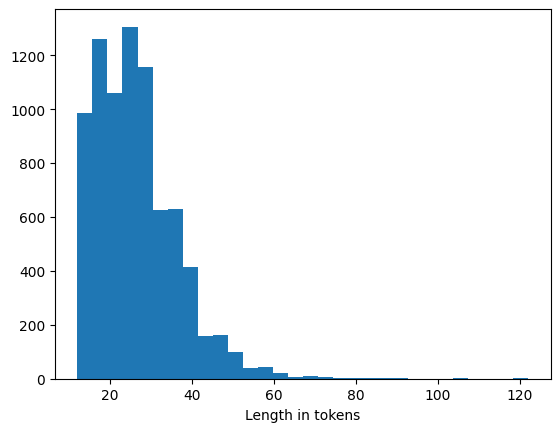

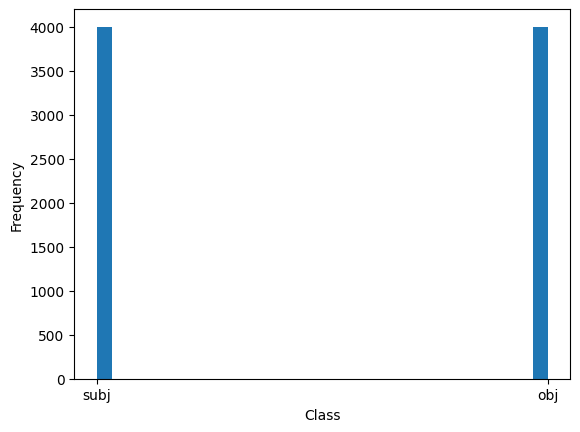

doc                                                                                                         label
----------------------------------------------------------------------------------------------------------  -------
<s> in all , this is a watchable movie that's not quite the memorable experience it might have been . </s>  subj
<s> when she hears about her plan going awry , she collapses . </s>                                         obj


In [13]:
_ = plt.hist([len(x.split()) for x, y in so_training], bins=30)
_ = plt.xlabel("Length in tokens")
_ = plt.show()

_ = plt.hist([y for x, y in so_training], bins=30)
_ = plt.ylabel("Frequency")
_ = plt.xlabel("Class")
_ = plt.show()

print(tabulate(so_training[4:6], headers=['doc', 'label']))

Helper code to map named labels to 0-based integers and back:

In [14]:
def label_as_string(y, vocab={True: 'subj', False: 'obj', 1: 'subj', 0: 'obj'}):
    """Map from boolean or integer to a string label"""
    return [vocab[b] for b in y]

def label_as_int(y, vocab={'subj': 1, 'obj': 0}):
    """Map from string to integer"""
    return np.array([vocab[b] for b in y], dtype=int)

In [15]:
label_as_string([True, False]), label_as_int(['subj', 'obj'])

(['subj', 'obj'], array([1, 0]))

<a name='sec:Baseline:_NBC_on_Features'></a>
## Baseline: NBC on Features

Let's start with a classifier we already know, this will also help us get comfortable with feature functions.

The NBC can be represented in terms of feature functions. Suppose a feature function $\mathbf h(x)$ maps $x$ to a space where each coordinate $d$ corresponds to a word in the vocabulary, and $h_d(x)$ is the number of times that word occurs in $x$. This would make $\mathbf h(x) \in \mathbb R^V$ a $V$-dimensional vector, but most of its coordinates would be in fact 0, since only up to $l = |x|$ words occur in $x$. If we use the notation $(f, n) \in \mathbf h(x)$ to denote all feature-count pairs for which the feature is a word and the count is not zero, we can rewrite the joint probability of the NB classifier as follows:

\begin{equation}
    P_{YX}(y, x) = P_Y(y)\prod_{(f, n) \in \mathbf h(x)} P_{F|Y}(f|y)^n
\end{equation}

In class we discussed how this view of NBC can be used to generalise it to feature types are not just words, but in this tutorial we will continue working with word counts.

To represent feature functions efficiently sklearn uses *vectorizers*. These classes turn a string into a sparse vector of coded features. Internally this builds a vocabulary of features and a data structure that is sparse like nested dicts, but much more efficient.

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

Take a moment to read the documentation of `CountVectorizer?` and play a bit with some examples.

The count vectorizer can be used to implement NBC. We simply need to count the unigrams, which in sklearn style is done as follows:

In [17]:
toy_vectorizer = CountVectorizer(ngram_range=(1,1), min_df=2)  # count all words that occur at least twice
# let's start with the first 5 sentences in the training set, just to see what this does
toy_vectorizer.fit(so_training[:5, 0])
print(tabulate(so_training[:5], headers=['doc', 'label']))
print()
print(f"The feature space contains {len(toy_vectorizer.get_feature_names_out())} features.\nThey are:")
for fname in toy_vectorizer.get_feature_names_out():
    print(f" F={fname}")
print()
print("Note that sklearn is pre-processing the text for us, getting rid of some punctuation marks and English stopwords. We also chose to keep only words that occurred at least twice (with min_df=2).")
print("To apply the feature function to text we use the method *transform*:")
h_x05 = toy_vectorizer.transform(so_training[:5, 0])
print(f" which gives us an object of shape {h_x05.shape}, as expected.")
print(h_x05.shape)
print("But that object is a sparse array (the zeros are not stored in it):")
print(h_x05)
print("In some occasions we may need a dense numpy array, when that's the case we can use *toarray*:")
print(h_x05.toarray())

doc                                                                                                                                                                                                                                                                                                                                                     label
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------  -------
<s> a depressingly retrograde , 'post-feminist' romantic comedy that takes an astonishingly condescending attitude toward women . </s>                                                                                                                                                                    

With count features we can implement the NB classifier. In sklearn it is called `MultinomialNB`.

Here are the necessary steps:
1. Train a CountVectorizer with `min_df=1` using all of the training data.
2. Then use it to train a MultinomialNB. We will set the alpha (the Laplace smoothing coefficient) to 0.7.
3. Finally, we the performance on the *test set*, reporting the results via sklearn's `classification_report` as well as `ConfusionMatrixDisplay.from_predictions`.


In [18]:
from sklearn.naive_bayes import MultinomialNB

Classification report
              precision    recall  f1-score   support

         obj       0.92      0.91      0.92       483
        subj       0.92      0.93      0.92       517

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000

Confusion matrix


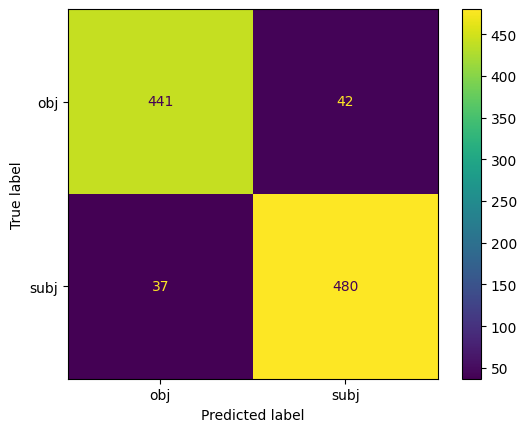

In [19]:
nb_vectorizer = CountVectorizer(ngram_range=(1,1), min_df=1)
nb_vectorizer.fit(so_training[:, 0])
nb_cls = MultinomialNB(alpha=0.7)
nb_cls.fit(nb_vectorizer.transform(so_training[:,0]), so_training[:, 1])

print("Classification report")
y_pred = nb_cls.predict(nb_vectorizer.transform(so_test[:, 0]))
print(classification_report(so_test[:, 1], y_pred))
print("Confusion matrix")
_ = ConfusionMatrixDisplay.from_predictions(so_test[:,1], y_pred)


<details>
    <summary><b>Curious how we got to alpha=0.7?</b></summary>

We got sklearn to perform a grid search using cross validation on the training set for us:

```python
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

cls_nb = Pipeline(
    [
        ('vect', CountVectorizer(ngram_range=(1,1))),
        ('clf', MultinomialNB(alpha=0.)),                 
    ]
)
# See the hyperparameters of the model (stuff like ngram_range and Laplace coefficient)
print(cls_nb.get_params())
# We can search for values of the hyperparameters of interest using cross validation
nb_grid = GridSearchCV(cls_nb, param_grid={'clf__alpha': np.linspace(0.1, 1., 10)}, cv=3)
nb_grid.fit(so_training[:, 0], so_training[:, 1])
print(nb_grid.best_params_)
print(classification_report(so_dev[:,1], nb_grid.predict(so_dev[:, 0])))
```

---    
</details>


<a name='sec:Bernoulli_GLM_on_Jax'></a>
## Bernoulli GLM on Jax

To train GLMs we need gradient-based optimisation. Nowadays we do not compute derivatives by hand, nor implement automatic differentiation, we use software that does that for us, efficiently and realiably.

In this tutorial you will use JAX, for you've already seen it in ML.

Because we need JAX's automatic differentiation, we will need to express our model's computations using building blocks available in JAX. Luckily for us, JAX implements something very much like numpy and something very much like scipy, so all we've been using so far in the course is likely already available in JAX.

In [70]:
import jax.numpy as jnp
import jax.scipy as jsp
from jax import grad, value_and_grad, random
from jax.nn import softplus  # useful to predict a strictly positive value
from jax.nn import sigmoid  # useful to predict a probability value
from jax.nn import softmax  # useful to predict a probability vector

<details>
    <summary><b>Curious about softplus, sigmoid and softmax?</b></summary>

In case you want to get a visual idea of what these functions look like, you can plot them:
   
```python
    
def np_sigmoid(x):
    """Our own numpy implementation of sigmoid"""
    return 1/(1 + np.exp(-x))

_ = plt.plot(np.linspace(-10, 10, 1000), np_sigmoid(np.linspace(-10, 10, 1000)))
_ = plt.title("Sigmoid function")
_ = plt.xlabel(r'$s$')
_ = plt.ylabel(r'sigmoid($s$) = $\frac{1}{(1+\exp(-s))}$')
plt.show()

def np_softplus(x):
    """This is our own numpy implementation of the softplus function"""
    return np.log(1 + np.exp(x))

_ = plt.plot(np.linspace(-10, 10, 1000), np_softplus(np.linspace(-10, 10, 1000)))
_ = plt.title("Softplus function")
_ = plt.xlabel(r'$s$')
_ = plt.ylabel(r'softplus($x$) = $\log(1+\exp(x))$')
plt.show()

# Compare exp and softplus
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
_ = axs[0].plot(np.linspace(-10, 10, 1000), np.exp(np.linspace(-10, 10, 1000)))
_ = axs[0].set_xlabel('s')
_ = axs[0].set_ylabel('exp(s)')
_ = axs[1].plot(np.linspace(-10, 10, 1000), np_softplus(np.linspace(-10, 10, 1000)))
_ = axs[1].set_xlabel('s')
_ = axs[1].set_ylabel('softplus(s)')
fig.suptitle("Compare exp and softplus")
fig.tight_layout(h_pad=1, w_pad=1)
plt.show()

def np_softmax(x, axis=-1):
    """Compute softmax values for each sets of scores in x."""
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

# let's get 1000 values for s0
s1 = np.linspace(-3.0, 3.0, 1000)
# for s2 and s3 we will have 1s and 0s (for the sake of illustration)
s = np.vstack([s1, np.ones_like(s1), np.zeros_like(s1)]).T

_ = plt.plot(s1, np_softmax(s)[:, 0], linewidth=2, label='output for k=1')
_ = plt.plot(s1, np_softmax(s)[:, 1], linewidth=2, label='output for k=2')
_ = plt.plot(s1, np_softmax(s)[:, 2], linewidth=2, label='output for k=3')
_ = plt.plot(s1, np_softmax(s).sum(-1), ':', c='black', linewidth=2, label='elementwise sum')
_ = plt.xlabel(r'$s_1$')
_ = plt.ylabel('softmax output')
_ = plt.title("Softmax function")
_ = plt.legend()
plt.show()
    
```

---    
</details>



In [71]:
# we need a random generator in order to create arrays in JAX
key = random.PRNGKey(0)

Here we will

1. describe the necessary functions to parameterise a Bernoulli GLM
2. implement a stochastic gradient-based procedure for parameter estimation.

Roughly this is what we need to do:

1. obtain a feature function $\mathbf h$ and compute it for all our data points
2. obtain some initial parameters for the linear function
3. implement the linear function that outputs the linear predictor
4. constrain the linear predictor to being a probability value
5. write a training loop, where we use some subset of the data to estimate the value of the log-likelihood function, use the gradient of that value with respect to model parameters to improve our parameter estimates

So, let's get started.

## Feature function

For feature function we are going to start with word counts (ie, `CountVectorizer`) and then we will normalise those into `tf-idf` features (see `TfidfTransformer`), which will help us take frequency information into account.

In [72]:
so_ff = Pipeline(
    [
        ('vect', CountVectorizer(ngram_range=(1,1), min_df=5)),
        ('tfidf', TfidfTransformer()),
    ]
)
so_ff.fit(so_training[:, 0], so_training[:, 1])

Pipeline(steps=[('vect', CountVectorizer(min_df=5)),
                ('tfidf', TfidfTransformer())])

In [73]:
so_training_h_sparse = so_ff.transform(so_training[:, 0])
so_dev_h_sparse = so_ff.transform(so_dev[:, 0])
so_test_h_sparse = so_ff.transform(so_test[:, 0])

In [74]:
# The number of input features is the $D$ in the formulas above.
num_features = so_training_h_sparse.shape[1]
num_features

4145

### Computing the Bernoulli parameter

To compute the Bernoulli parameter associated with each text input $x$ we start with a linear function of the features $\mathbf h(x)$, for which we needs weight and a bias. So here we obtain those.

Let's obtain $\boldsymbol\theta$ for binary classification using `num_features` input features.

In [75]:
def init_params_linear1(num_features, key):
    """
    num_features: dimensionality of the feature space
    key: a JAX random generator

    Return w with shape [num_features] and bias with shape []
    """
    w = random.uniform(key, shape=(num_features,))
    b = random.uniform(key)
    return w, b

In [26]:
key, param_key = random.split(key, 2)
w, b = init_params_linear1(num_features, param_key)
assert w.shape == (num_features,)
assert b.shape == ()

Below, we implement a real-valued linear function $\mathbf w^\top \mathbf h(x) + b$ with $\mathbf w\in \mathbb R^D$ and $b\in \mathbb R$ in JAX.

Study our solution below for a bit before proceeding.

In [27]:
def linear1(inputs, *, w, b):
    """
    inputs: a collection of inputs [batch_size, num_features]
      we normally program our models supporting the ability to perform the same operations
      for multiple documents at once
      we do so by "batching" documents together, so our first dimension is used
      to iterate over different documents
    w: parameters (vector of size num_features)
      see that the parameters do not depend on batch size
      that's because parameters are a property of the model and batch size isn't
    b: parameters (single scalar)

    Return the following computation
        \sum_{d=1}^D x[d] * w[d] + b
    for each document x[n] amongst the inputs.
    """
    # SOLUTION
    # elementwise product
    # [batch_size, num_features]
    out = w * inputs  # by default this multiplication happens elementwise along the last dimension of the tensor
    # reduce the feature dimension via sum
    # [batch_size]
    out = jnp.sum(out, axis=-1)
    # add bias
    out = out + b
    # [batch_size]
    return out

<a name='ungraded-1'></a> **Ungraded Exercise 1 - Space and time complexity of the linear model**

Study the implementation above, and answer:

* What's the cost (in units of memory) to store our linear model? Represent it as a function of $D$.
* Express the time to compute the linear predictor for a data point $x$, assume the feature function takes time $\mathcal O(D)$ to run.


<details>
    <summary> <b>Click to see a solution</b> </summary>

* To store the model we need $D$ weights (one for each feature) and a single bias. Hence, the storage cost is $\mathcal O(D)$.
* To compute a linear predictor for $x$, we need
    1. to obtain the feature vector $\mathbf h(x)$, the exercise says this takes time proportional to $D$;
    2. then we need to compute a dot product $\mathbf w^\top\mathbf h(x) = \sum_{d=1}^D w_dh_d(x)$, which runs in time proportional to $D$;
    3. we also need to add a bias, this takes one unit of time; so altogether we have so far we have $\mathcal O(D + D + 1) = \mathcal O(D)$;
    
---
    
</details>      


As the dev set is not too large, we will convert it to a dense numpy array, so that we can use it within JAX.

In [77]:
so_dev_h = so_dev_h_sparse.todense()

# DO NOT use .toarray for the training data, you could run out of memory

Unlike sklearn, JAX does not understand string labels, so we must convert our labels to integers:

In [78]:
so_training_y = label_as_int(so_training[:, 1])
so_dev_y = label_as_int(so_dev[:, 1])
so_test_y = label_as_int(so_test[:, 1])

Now we can test our `linear1` function:

In [79]:
# We can give it a single document, then we get a single output
assert linear1(so_dev_h[0:1], w=w, b=b).shape == (1,)

In [80]:
# or we can give it 10 documents, then we get 10 outputs
assert linear1(so_dev_h[0:10], w=w, b=b).shape == (10,)

In [81]:
# or we can give it the entire dev set, and get one output per doc in the dev set
assert linear1(so_dev_h, w=w, b=b).shape == (so_dev_h.shape[0],)

For this statistical model, a binary classifier, we need to map $x$ to a probability value (the Bernoulli parameter), but the linear function is not constrained accordingly:


In [82]:
assert jnp.all(linear1(so_dev_h, w=w, b=b) >= 0.) and jnp.all(linear1(so_dev_h, w=w, b=b) <= 1.) == False

For that, jax offers the sigmoid function:

In [83]:
def make_prob(linear_predictor):
    """
    Properly constrains the linear predictor in order to parameterise a Bernoulli distribution.

    linear_predictor: an array of linear predictors with shape [batch_size]
    """
    return sigmoid(linear_predictor)  # this a JAX function

which constrains everything as we wanted:

In [84]:
assert jnp.all(make_prob(linear1(so_dev_h, w=w, b=b)) >= 0.) and jnp.all(make_prob(linear1(so_dev_h, w=w, b=b)) <= 1.) == True

Next we assess the Bernoulli log pmf using JAX differentiable code. Luckily for us JAX has a [`jax.scipy.sats`](https://jax.readthedocs.io/en/latest/jax.scipy.html#jax-scipy-stats) module, which contains many of our favourite distributions.

In [85]:
def bernoulli_logpmf(y, p):
    """
    y: a batch of binary values with shape [batch_size]
    p: a batch of probability values with shape [batch_size]

    Return \log Bernoulli(y[n]|p[n]) for each element y[n] in the batch.
    """
    # this is \log p when y is 1 and \log(1-p) when y is 0
    # we could implement it ourselves, for example:
    #   y * jnp.log(p) + (1-y) * jnp.log(1-p)
    # but it's always better to use an existing stress-tested implementation : )
    return jax.scipy.stats.bernoulli.logpmf(y, p=p)

In [86]:
assert jnp.allclose(jnp.exp(bernoulli_logpmf(np.array([1, 1, 1]), np.array([0.9, 0.5, 0.1]))), np.array([0.9, 0.5, 0.1]), 1e-6)
assert jnp.allclose(jnp.exp(bernoulli_logpmf(np.array([0, 0, 0]), np.array([0.9, 0.5, 0.1]))), np.array([0.1, 0.5, 0.9]), 1e-6)

<details>
    <summary><b>Check this, if you'd like to draw samples from Bernoulli in JAX</b></summary>

```python
y_sample = random.bernoulli(key, p=make_prob(linear1(bin_dev_h, w=w, b=b)))
```
---    
</details>


We can also check the performance of the most probable class (for an untrained model):

In [88]:
def bernoulli_mode(p):
    return jnp.where(p > 0.5, 1, 0)

In [89]:
assert jnp.all(bernoulli_mode(np.array([0.51, 0.1, 0.8])) == np.array([1, 0, 1]))

Finally, let's test our untrained Bernoulli GLM on the dev set. For predictions, we will use the mode of the predicted Bernoulli distributions.

              precision    recall  f1-score   support

         obj       0.00      0.00      0.00       515
        subj       0.48      1.00      0.65       485

    accuracy                           0.48      1000
   macro avg       0.24      0.50      0.33      1000
weighted avg       0.24      0.48      0.32      1000



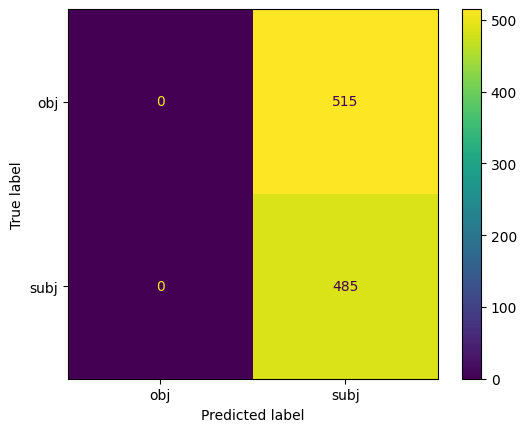

In [90]:
y_best = bernoulli_mode(make_prob(linear1(so_dev_h, w=w, b=b)))
print(classification_report(so_dev[:,1], label_as_string(np.array(y_best)), zero_division=0))
_ = ConfusionMatrixDisplay.from_predictions(so_dev[:,1], label_as_string(np.array(y_best)))

The next piece of code will plot the Bernoulli pmfs that our GLM predicts for the 16 first documents in the dev set. You will be able to reuse this code later to analyse a trained model.

This model is not trained yet, so don't be surprised if the plots aren't interesting yet.

The plots show samples from the conditional model Y|X=x.
The red vertical line shows the observation Y=y for X=x.


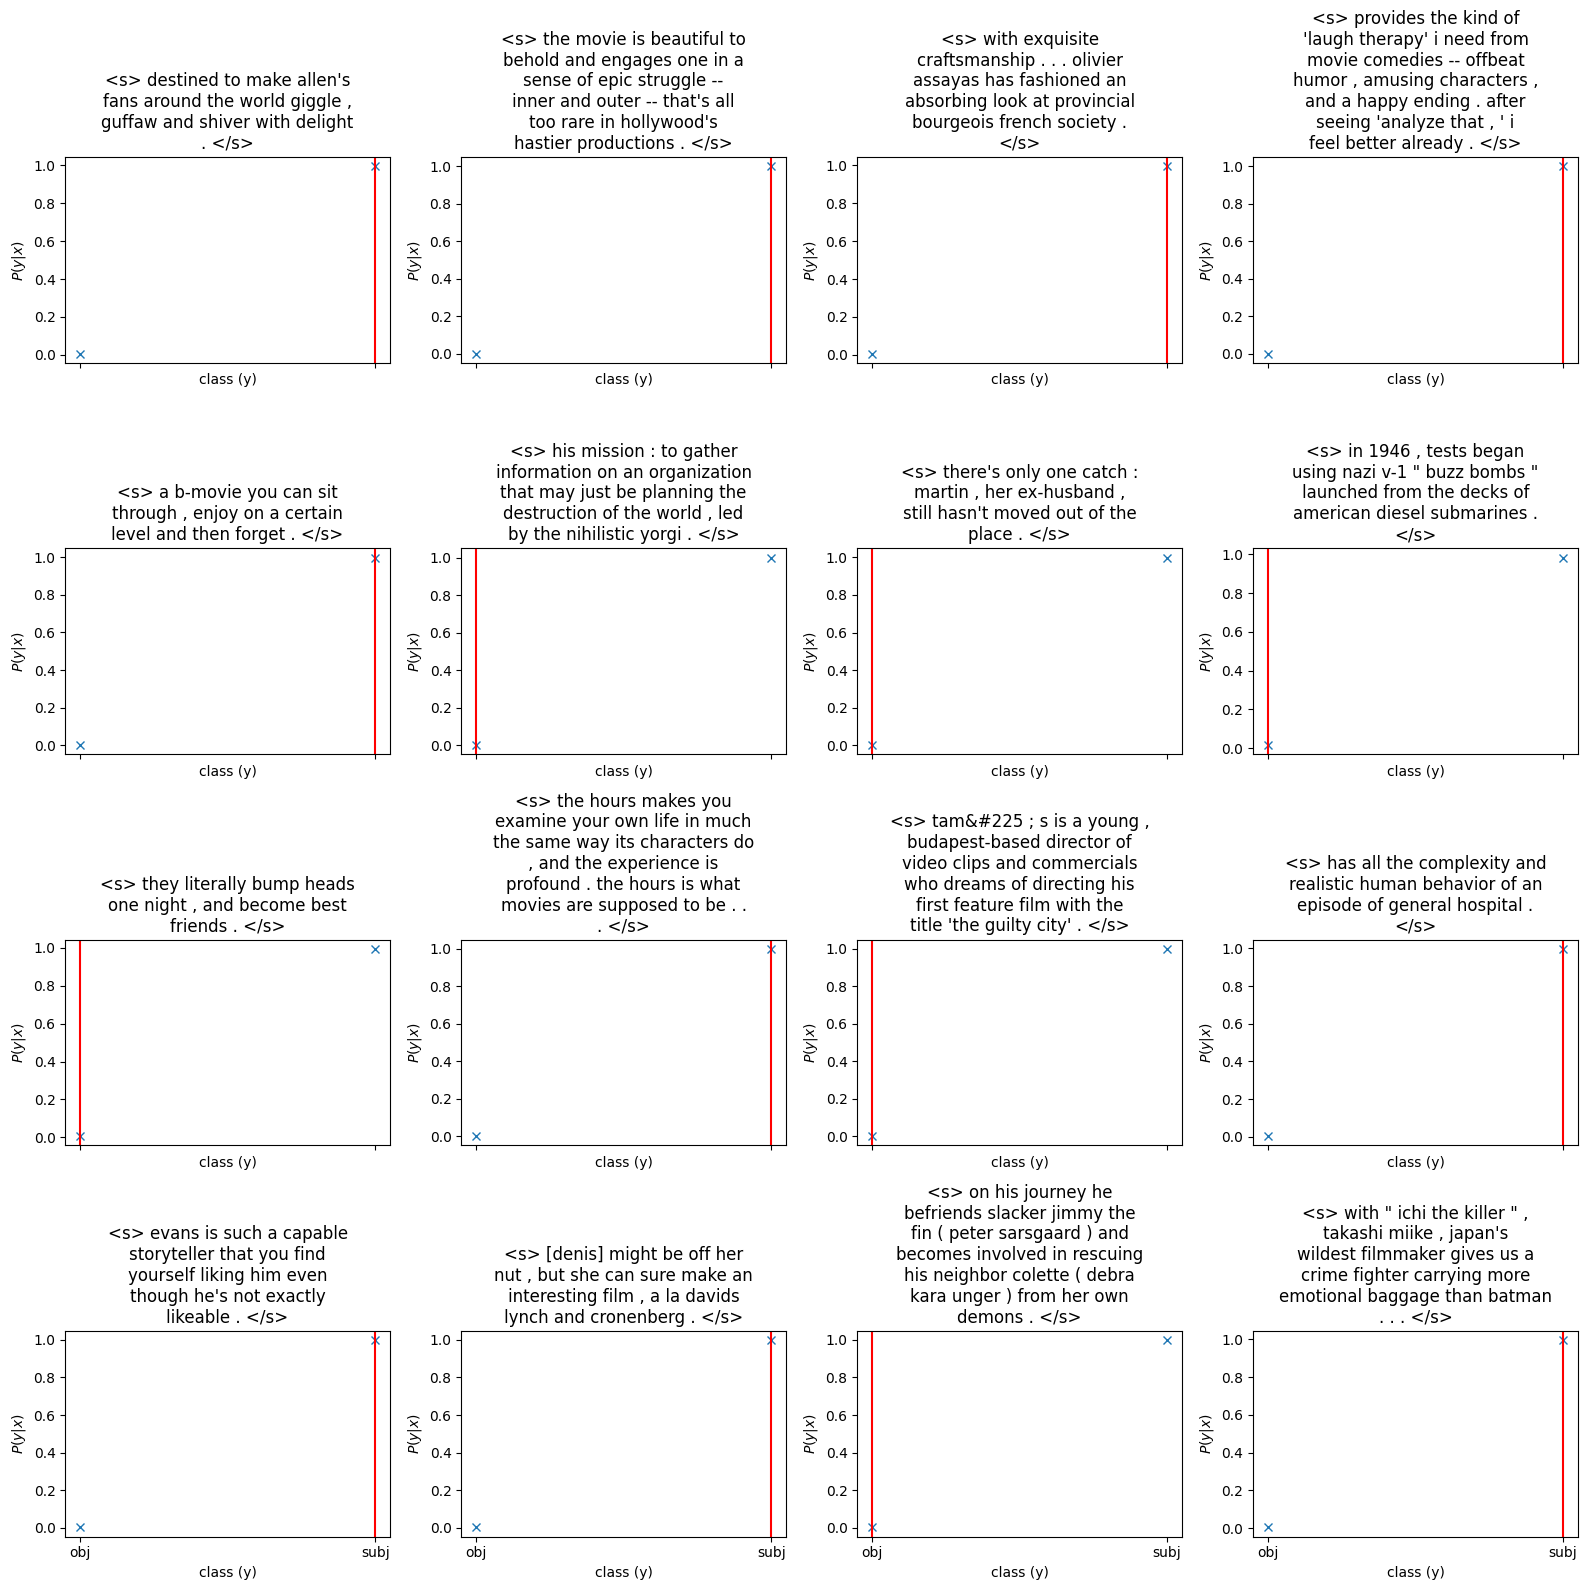

In [91]:
import textwrap

fig, axs = plt.subplots(4, 4, sharex=True, figsize=(16, 16))

print("The plots show samples from the conditional model Y|X=x.\nThe red vertical line shows the observation Y=y for X=x.")

for i in range(16):
    x, y = so_dev[i, 0], so_dev[i, 1]
    h = so_ff.transform([x]).toarray()
    prob = make_prob(linear1(h, w=w, b=b)).item()

    _ = axs[i//4,i%4].set_title("\n".join(textwrap.wrap(x, 30)))
    _ = axs[i//4,i%4].plot(label_as_string([0, 1]), [1-prob, prob], 'x')
    _ = axs[i//4,i%4].axvline(y, c='red')
    _ = axs[i//4,i%4].set_ylabel(r"$P(y|x)$")
    _ = axs[i//4,i%4].set_xlabel("class (y)")

fig.tight_layout(h_pad=1, w_pad=1)

### Parameter estimation

For a Bernoulli GLM, our likelihood function is:
\begin{equation}
\mathcal L_{\mathcal D}(\boldsymbol\theta) = \sum_{n=1}^N \log \mathrm{Bernoulli}(y^{(n)}|g(x^{(n)}; \boldsymbol \theta))
\end{equation}

And for stochastic gradient-based optimisation we will approximate it using mini batches.


In [42]:
from tqdm.auto import tqdm
from collections import defaultdict

It's important to regularise our model to try and avoid overfitting, for now we do so via L2-regularisation (i.e., a penalty on the L2-norm of the parameter vector). We implement L2 below.

In [43]:
def l2_regulariser(w, b):
    """Here we implement the L2 regulariser for you"""
    return jax.numpy.linalg.norm(w.flatten(), 2) + jax.numpy.linalg.norm(b.flatten(), 2)

In [44]:
assert jnp.isclose(l2_regulariser(np.array([1., 2., 3.]), np.array(4.)), np.sqrt(1**2 + 2**2 + 3**2) + np.sqrt(4**2), 1e-3)

Below we use [jax.scipy.stats](https://jax.readthedocs.io/en/latest/_autosummary/jax.scipy.stats.bernoulli.logpmf.html#jax.scipy.stats.bernoulli.logpmf) functions to define a *loss function* for the Bernoulli GLM model. Our loss function is the **negative** of the L2-regularised log-likelihood function.

Study our implementation for a bit before proceeding.

In [45]:
def bernoulli_loss(w, b, *, inputs, targets, l2weight=0.):
    """
    w: weights of the linear model with shape [num_features]
    b: bias of the linear model with shape []
    inputs: h(x) with shape [batch_size, num_features]
    targets: y with shape [batch_size]
    l2weight: this is the lambda > 0 in the formula, the weight of the regulariser
    """
    # SOLUTION
    s = linear1(inputs, w=w, b=b)
    p = make_prob(s)
    l2 = l2_regulariser(w=w, b=b)
    return - jax.scipy.stats.bernoulli.logpmf(targets, p=p).mean(0) + l2weight * l2

<a name='ungraded-2'></a> **Ungraded Exercise 2 - Analysing the loss for the Bernoulli GLM**

Study the implementation above, then assuming $\lambda$ is the `l2weight`, $x$ is a single input and $y$ its target, what options are correct:

1. The loss is numerically equivalent to $-\log \mathrm{Bernoulli}(y|\mathrm{sigmoid}(\mathbf w^\top \mathbf h(x) + b) + \lambda \sqrt{b^2 +\sum_{d=1}^D w_d^2}$
2. The first term in the loss is numerically equivalent to $-\log \mathrm{sigmoid}(\mathbf w^\top \mathbf h(x) + b)$ if $y=1$ and $-\log (1-\mathrm{sigmoid}(\mathbf w^\top \mathbf h(x) + b))$ if $y=0$
3. If we had multiple inputs (and their corresponding targets), the first term of the loss would be the negative of the average of the log probability that our model assigns to the targets given the inputs
4. For a single observations, the first term of the loss is $0$ if the model is right and $-1$ if the model is wrong.


<details>
    <summary> <b>Click to see a solution</b> </summary>

1. Correct, the log pmf is precisely the log of the Bernoulli pmf, and the Bernoulli parameter is precisely the sigmoid of the linear predictor, besides the L2 regulariser is defined as the squared-root of the sum of squared parameters.
2. Correct, the first term of the loss is negative of the logarithm of the mass assigned to the target, the probability mass is precisely the Bernoulli parameter value when the target is 1, when the target is 0 the mass is 1 minus the Bernoulli parameter.
3. Correct, when we have multiple observations, the loss is based on the average of their log probabilities under the model, that's what the `.mean(0)` part of the loss does.
4. Incorrect, the first term is a log probability of the positive (1) or negative (0) observed outcome.
    
---
    
</details>      


In [92]:
test_case_inputs = np.array([[1., 0.], [0., 1.], [0., 0.]])
test_case_targets = np.array([1, 0, 1])
test_case_w = np.array([-1., 2.])
test_case_b = np.array(1.)
# the linear predictor is correct
assert jnp.allclose(linear1(test_case_inputs, w=test_case_w, b=test_case_b), np.array([0., 3., 1]), 1e-3), "Did you remember to compute dot-product with w and add the bias b?"
# the probability is correct
assert jnp.allclose(make_prob(np.array([0., 3., 1.])), np.array([0.5, 0.952574, 0.73105]), 1e-3), "Did you use the sigmoid function?"
# the regulariser is correct
assert jnp.isclose(l2_regulariser(test_case_w, test_case_b), np.array(3.23606), 1e-3), "Did you change the regulariser code?"
assert bernoulli_loss(test_case_w, test_case_b, inputs=test_case_inputs, targets=test_case_targets).shape == (), "Did you remember to take the mean?"
# the (unregulariser) loss function is correct
assert jnp.isclose(bernoulli_loss(test_case_w, test_case_b, inputs=test_case_inputs, targets=test_case_targets), - np.mean([np.log(0.5), np.log(1-0.952574), np.log(0.73105)]), 1e-3), "Did you remember the minus?"
# the regulariseed loss function is correct
assert jnp.isclose(bernoulli_loss(test_case_w, test_case_b, inputs=test_case_inputs, targets=test_case_targets, l2weight=1.0), - np.mean([np.log(0.5), np.log(1-0.952574), np.log(0.73105)]) + np.array(3.23606), 1e-3), "Did you remember the minus?"

Here we will pack the loss code for you in a way that can be used for automatic differentiation, and we will then compute the gradient with respect to $\mathbf w$ and $b$:

In [47]:
from functools import partial  # partial allows us to fix some of the arguments of a function

loss_fn = partial(
    bernoulli_loss, # we want to fix some of the arguments of bernoulli_loss
    inputs=so_dev_h,   # namely, the part that concerns the observed data, both h(x)
    targets=so_dev_y,  # and y
    l2weight=0.     # we also want to fix the hyperparameters,
) # this creates a loss function which is a function of w and b (exactly as we would like it to be)

# Now we tell JAX to evaluate the loss_fn for the parameter values (w, b) that we currently have
#  and compute partial derivatives for them
loss, (grad_w, grad_b) = value_and_grad(loss_fn, (0, 1))(w, b)
# the partial derivatives together form the gradient vector, which always has the same dimensionality as the parameter vector
assert grad_w.shape == (num_features,)
assert grad_b.shape == ()
# the loss, of course, is a scalar
assert loss.shape == ()

print(loss.item())

1.0736850500106812


This is it, you have all the ingredients needed to prescribe the model (its parameterisation in terms of $\mathbf h(x)$ and $\boldsymbol\theta$, to use it (i.e., compute log probability for a given $(x, y)$ pair), and to train it (i.e., estimate its paramters using regularised MLE).

We will wrap everything nicely for you into a single class, so that you can experiment with it.

<a name='sec:Python/JAX_GLM_Class'></a>
# Python/JAX GLM Class

<a name='ungraded-3'></a> **Ungraded Exercise 3 - GLM class**

Study the class below, it implements a general purpose GLM for a conditional distribution with a 1-dimensional statistical parameter. This can be used, for example, for binary classification and for Poisson regression. This class lacks implementation for a couple of methods, but you should not attempt to implememtn it. Instead, those are implemented in classes that specialise this one. For example, study the BinaryClassifier class that we provide right after GLM1. That class, will complete the specfication of GLM1 by making it a Bernoulli conditional model.

In [93]:
class GLM1:
    """
    This class contains all functionality that are shared across GLMs for single parameter distributions.
    Subclasses of this class must only implement the parts that are specific to their choice of distribution.
    For example,
        GLM1 uses the mode for prediction, but how to compute the mode depends on which distribution we have.
        GLM1 knows that the activation function is needed in order to constrain the linear predictor correctly,
         but the choice of activation function will depend on the distribution we have.
    """

    def __init__(self, feature_function, seed=0):
        self.feature_function = feature_function
        self.num_features = len(feature_function.get_feature_names_out())
        self.key = random.PRNGKey(seed)

    def feature_names(self):
        return self.feature_function.get_feature_names_out()

    def random_parameters(self):
        """
        Return randomly initialised weights and biases
        """
        w = random.uniform(self.key, shape=(self.num_features,))
        b = random.uniform(self.key)
        return w, b

    def l2(self, w, b):
        """Compute the L2 regulariser"""
        return jax.numpy.linalg.norm(w.flatten(), 2) + jax.numpy.linalg.norm(b.flatten(), 2)

    def linear(self, inputs, *, w, b):
        """
        inputs: a collection of inputs [batch_size, num_features]
        we normally program our models supporting the ability to perform the same operations
        for multiple documents at once
        we do so by "batching" documents together, so our first dimension is used
        to iterate over different documents
        w: parameters (vector of size num_features)
        see that the parameters do not depend on batch size
        that's because parameters are a property of the model and batch size isn't
        b: parameters (single scalar)

        Return x * w + b
        """
        # elementwise product
        # [batch_size, num_features]
        out = w * inputs  # by default this multiplication happens elementwise along the last dimension of the tensor
        # reduce the feature dimension via sum
        # [batch_size]
        out = jnp.sum(out, axis=-1)
        # add bias
        out = out + b
        # [batch_size]
        return out

    def activation(self, linear_predictor):
        """
        Constrain the linear predictor

        linear_predictor: w*h(x)+b with shape [batch_size]
        """
        return 1 / (1 + np.exp(-linear_predictor))  # sigmoid functie

    def g(self, inputs, *, w, b):
        """
        Compute the statistical parameter of the conditional model.

        inputs: h(x) with shape [batch_size, num_features]
        w: weights with shape [num_features]
        b: bias with shape []

        Return g(x) with shape [batch_size]
        """
        linear_predictor = self.linear(inputs, w=w, b=b)
        parameter = self.activation(linear_predictor)
        return parameter

    def decide(self, g):
        """
        Decide what output better represents this pmf/pdf.

        g: statistical parameter of the distribution with shape [batch_size]
        """
        raise NotImplementedError("Implement me in a subclass!")


    def log_p(self, targets, g):
        """
        Return log probability mass (or density) of targets given the statistical parameter.

        targets: y with shape [batch_size]
        g: statistical parameter of the distribution with shape [batch_size]
        """
        raise NotImplementedError("Implement me in a subclass!")

    def loss(self, w, b, *, inputs, targets, l2weight=0.):
        """
        Compute the regularised negative log-likelihood of the model given observed (x, y) pairs.

        w: weights with shape [num_features]
        b: bias with shape []
        inputs: h(x) with shape [batch_size, num_features]
        targets: y with shape [batch_size]
        l2weight: contribution of the L2 regulariser

        Return - \sum_{n=1}^N P(Y=y[n]|X=x[n]) + L2(w,b)
        """
        return - self.log_p(targets, g=self.g(inputs, w=w, b=b)).mean(0) + l2weight * self.l2(w, b)

    def predict(self, inputs, *, w, b):
        """
        Predict y for h using the mode of the conditional distribution.

        inputs: h(x) with shape [batch_size, num_features]
        w: weights with shape [num_features]
        b: bias with shape []

        Return \argmax_y P(Y=y|X=x)
        """
        return self.decide(self.g(inputs, w=w, b=b))

    def validate(self, inputs, targets, *, w, b):
        """
        Predict y for h and compare it to y_true using an appropriate metric.

        inputs: h(x) with shape [batch_size, num_features]
        targets: true targets with shape [batch_size]
        w: weights with shape [num_features]
        b: bias with shape []

        Return performance metric (e.g., f1 for classification, MAE for regression)
        """
        raise NotImplementedError("Implement me in a subclass!")

Here we specialise this class to the case of Binary classification with a Bernoulli conditional model.

In [94]:
from sklearn.metrics import classification_report


class BinaryClassifier(GLM1):

    def __init__(self, feature_function, seed=0):
        super().__init__(feature_function, seed=seed)

    def activation(self, linear_predictor):
        """For Binary classification we need to parameterise a Bernoulli, thus we constrain the linear predictor using sigmoid"""
        return sigmoid(linear_predictor)

    def decide(self, g):
        """
        For the binary classifier, we will base decisions on the mode of the Bernoulli,
        which is the outcome that receives most mass.
        """
        return jnp.where(g > 0.5, 1, 0)

    def log_p(self, targets, g):
        """
        We use JAX scipy to return the log pmf of the Bernoulli
        """
        return jax.scipy.stats.bernoulli.logpmf(targets, p=g)

    def validate(self, inputs, targets, *, w, b):
        """For binary classification we report macro F1"""
        y_pred = self.predict(inputs, w=w, b=b)
        metrics = classification_report(targets, y_pred, output_dict=True, zero_division=0)
        return metrics['macro avg']['f1-score']

<a name='ungraded-4'></a> **Ungraded Exercise 4 - Code for parameter estimation**

Here we share some code useful for training a model. Study the steps of the training algorithm.

In [95]:
# **YOU SHOULD NOT NEED TO EDIT THIS CELL**

from functools import partial


def get_batcher(data_size, batch_size, replace=False, rng=np.random.RandomState(1)):
    """
    Return an iterable for indices of data points organised as batches of a given size (the last batch is potentially shorter).
    """
    if rng is None:
        permutation = np.arange(data_size)
    else:
        permutation = rng.permutation(data_size)
    i = 0
    while i < data_size:
        yield permutation[i:i+batch_size]
        i += batch_size


def train_model(
    model, training_h_sparse, training_y, dev_h_sparse, dev_y,
    num_epochs=5, batch_size=500, validate_freq=10,
    l2weight=1e-6, lr0=10., step_overwrite=0, log=None,
    w=None, b=None,
    rng=None):
    """
    model: an instance of GLM1 specialised to a type of distribution
    training_h_sparse: a scipy sparse matrix of features for the training data
    training_y: a numpy array of targets for the training data
    dev_h_sparse: a scipy sparse matrix of features for the validation data
    dev_y: a numpy array of targets for the validation data
    num_epochs: total number of passes over the entire training data
    batch_size: how many instances are used for a single gradient step
    validate_freq: how often (in number of gradient steps) we compute performance of the validation set
    l2weight: the contribution of the L2 regulariser
    lr0: the initial learning rate
    step_overwrite: when you continue training, you can overwrite the step number (which affects the schedule of the learning rate)
    log: when you continue training, you can reuse an existing log
    w: use this to continue training (instead of training from scratch)
    b: use this to continue training (instead of training from scratch)
    rng: numpy random number generator, use it for reproducibility
    """

    if w is None or b is None:  # we start with some random parameters
        w, b = model.random_parameters()

    dev_h = dev_h_sparse.toarray()
    data_size = training_h_sparse.shape[0]
    if log is None:
        log = defaultdict(list)

    # It's good to always run the model before training,
    # just to catch any problems and to log its current performance
    log['val_metric'].append(model.validate(dev_h, dev_y, w=w, b=b))
    log['val_loss'].append(model.loss(w, b, inputs=dev_h, targets=dev_y, l2weight=l2weight))

    # and we will train for a certain number of steps
    total_steps = num_epochs * len(list(get_batcher(data_size, batch_size)))
    step = step_overwrite  # and sometimes we have already trained for a bit

    with tqdm(range(total_steps), desc='MLE') as bar:  # tqdm is a very cool progressbar :)
        # we pass over the entire data a number of times
        for epoch in range(num_epochs):
            # but do so in random order, and process one mini batch at a time
            for ids in get_batcher(data_size, batch_size, rng=rng):

                # our learning rate decays with time, this is something needed for the theory of stochastic optimisation to check out
                lr = lr0/np.log10(10+step)

                # we prepare our loss function
                # essentially, we fix the data it is based on (the inputs and targets in the mini batch)
                # and fix its hyperparameters
                # the only things that can vary are the parameters (w, b)
                loss_fn = partial(
                    model.loss,
                    inputs=training_h_sparse[ids].toarray(),  # we need dense arrays but we better not store all dense arrays (else we run out of memory)
                    targets=training_y[ids],
                    l2weight=l2weight
                )
                # here we tell JAX to evaluate the loss function at the point (w, b)
                # and also compute its partial derivatives at that point
                loss_value, (grad_w, grad_b) = value_and_grad(loss_fn, (0, 1))(w, b)

                # because we have a *loss* we will subtract the gradient (scaled by the learning rate)
                # from the current parameter values
                w -= lr * grad_w
                b -= lr * grad_b

                # Here we log some information for analysis later on
                log['loss'].append(loss_value.item())
                if step % validate_freq == 0:
                    log['val_metric'].append(model.validate(dev_h, dev_y, w=w, b=b))
                    log['val_loss'].append(model.loss(w, b, inputs=dev_h, targets=dev_y, l2weight=l2weight))
                bar.set_postfix({'epoch': epoch + 1, 'step': f"{step:4d}", 'lr': f"{lr:.4f}", 'loss': f"{loss_value:.4f}", 'val_loss': f"{log['val_loss'][-1]:.4f}", 'val_metric': log['val_metric'][-1]})
                bar.update()
                step += 1

    return (w, b), log

<a name='sec:Binary_classification_experiment'></a>
## Binary classification experiment

From now on, we will use the following feature function. In NBC, we use counts, but counts are not a great idea for linear and generalised linear models. That's because raw counts vary with document length, which makes the magnitude of the dot product $\mathbf w^\top\mathbf h(x)$ also vary a lot with document length.

It's better to take frequency information into account, we wil be using a tf-idf transformation of the raw counts, sklearn can do that for us.

In [96]:
bin_ff = Pipeline(
    [
        ('vect', CountVectorizer(ngram_range=(1,1), min_df=5)), # we will be discarding tokens less frequent than 5
        ('tfidf', TfidfTransformer()),
    ]
)
bin_ff.fit(so_training[:, 0])

bin_training_h_sparse = bin_ff.transform(so_training[:, 0])
bin_training_y = label_as_int(so_training[:, 1])

bin_dev_h_sparse = bin_ff.transform(so_dev[:, 0])
bin_dev_y = label_as_int(so_dev[:, 1])

bin_test_h_sparse = bin_ff.transform(so_test[:, 0])
bin_test_y = label_as_int(so_test[:, 1])

bin_cls = BinaryClassifier(bin_ff)

In [52]:
# This should take a couple of minutes (the progress bar should give you a reliable estimate)
# for a faster run reduce num_epochs or increase batch_size
# of course, do expect changes in performance
# you can use lr0 and l2weight to affect the optimiser and the objective function
(bin_w, bin_b), bin_log = train_model(
    bin_cls,
    bin_training_h_sparse,
    bin_training_y,
    bin_dev_h_sparse,
    bin_dev_y,
    lr0=5, # vary this to change the initial learning rate
    l2weight=1e-4, # vary this to control regularisation
    batch_size=100, # on GPU you can use larger batches
    num_epochs=10, # use more to train for longer
    rng=np.random.RandomState(42),
)

MLE:   0%|          | 0/800 [00:00<?, ?it/s]

We should always visualise the training loss, the validation loss, and some performance metric.

The validation loss is the log-likelihood of the model given the validation data only (not the training data). If that curve starts going up, while the training loss curve is going down, we detect overfitting (a situation where the model is memorising patterns that are specific to the training data and are of no help to classify heldout data).

The metric for classification helps us see how the most probable class decision rule performs for heldout data.

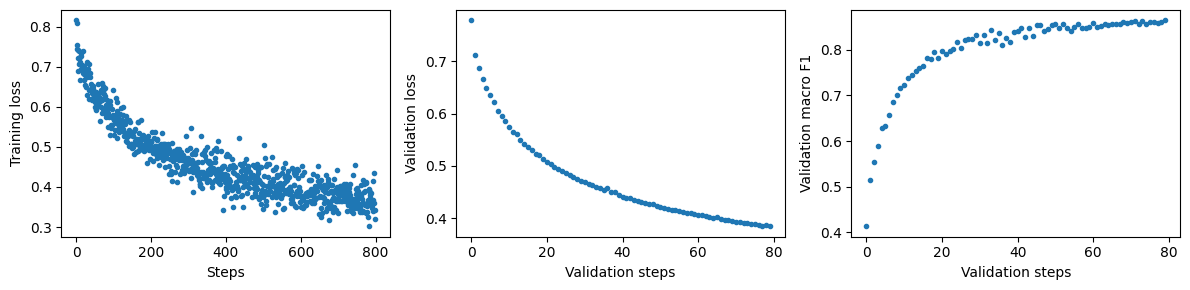

In [53]:
skip = 1 # skipping the fully first evaluation (fully untrained model)
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
_ = ax[0].plot(np.arange(len(bin_log['loss'][skip:])), bin_log['loss'][skip:], '.')
_ = ax[0].set_ylabel("Training loss")
_ = ax[0].set_xlabel("Steps")
_ = ax[1].plot(np.arange(len(bin_log['val_loss'][skip:])), bin_log['val_loss'][skip:], '.')
_ = ax[1].set_ylabel("Validation loss")
_ = ax[1].set_xlabel("Validation steps")
_ = ax[2].plot(np.arange(len(bin_log['val_metric'][skip:])), bin_log['val_metric'][skip:], '.')
_ = ax[2].set_ylabel("Validation macro F1")
_ = ax[2].set_xlabel("Validation steps")
fig.tight_layout(h_pad=1, w_pad=1)

We should always visualise the magnitude of the weights. If they get too large we typically have numerical instabilities and/or overfitting.

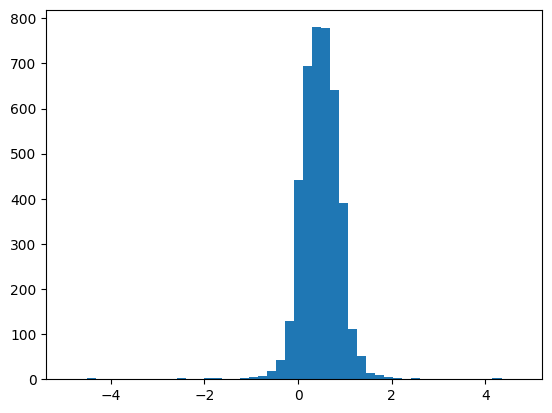

In [54]:
_ = plt.hist(np.array(bin_w).flatten(), bins=50)

And we can have a look at the bias term:

In [55]:
bin_b

Array(-1.1450648, dtype=float32)

We can also order the features by importance and inspect them

In [56]:
print("20 features with large positive weight")
for f, w in sorted(zip(bin_cls.feature_names(), np.array(bin_w)), key=lambda pair: pair[1], reverse=True)[:20]:
    print(f, w)

20 features with large positive weight
it 4.729985
its 4.3370447
movie 4.243134
film 4.0035286
you 2.7067492
like 2.5524645
than 2.525875
that 2.2814376
this 2.2121005
director 2.078554
good 2.0178564
too 1.9855756
but 1.9119594
much 1.8613985
funny 1.8280597
script 1.8210577
more 1.7787542
us 1.7763115
most 1.7384621
if 1.7249538


<a name='graded-1'> **Graded Exercise 1 - Subjectivity classifier** </a>

Here you will experiment with various Bernoulli GLMs on the subjectivity dataset using the feature function we provided you with. Here we recommend 100 epochs, more can be better, less can be okay too. Without GPUs, more than 100 epochs may be too slow.

1. Train for 100 epochs with regularisation 1e-4. Plot the log information (training/validation loss and metric curves). Comment on when the classifier converged (when the curves got roughly flat), if at all. Make a good quality plot for full points.

2. Train for 100 epochs with and without regularisation (use l2weight of 0 and of 1e-4). Plot the log information (training/validation loss and metric curves). Also plot a histogram with the flattened vector of weights (no need for bias), compare the histograms for the variant with and without regularisation. Discuss whether you see any risk for overfitting with this model (it's not always the case that overfitting happens).

3. For your model with regularisation, assess the model on the test set (display a classification report and the confusion matrix). For that model, inspect some features that received large positive weights and large negative weights. Discuss whether the features you see there are plausibly related to subjectivity and objectivity.


Do not expect the performance to necessarily match the NBC. This dataset is simple enough that NBC is a *strong baseline*. Also, our feature function is not very complex, because we want to keep the notebook tutorial easy to use.


In [57]:
from sklearn import subjectivity

(ber_w, ber_b), ber_log = train_model(
    bin_cls,
    bin_training_h_sparse,
    bin_training_y,
    bin_dev_h_sparse,
    bin_dev_y,
    lr0=5, # vary this to change the initial learning rate
    l2weight=1e-4, # vary this to control regularisation
    batch_size=100, # on GPU you can use larger batches
    num_epochs=100, # use more to train for longer
    rng=np.random.RandomState(42),
)

	CONTRIBUTE YOUR SOLUTION/DISCUSSION

---

<a name='ungraded-5'></a> **Ungraded Exercise 5 - Change the feature function**

When you are done with the graded part of the assignment, try changing the feature function (for example, you can count word pairs), see if you can affect the result in a meaningful way (esp, part 3 of the exercise).

<a name='sec:Ordinal_regression_experiment'></a>
## Ordinal regression experiment

*Semantic text similarity* is a task where humans are asked to assess the extent to which two texts $x=(a,b)$, text $a$ and text $b$, convey the same meaning. We gather human responses by asking them to assign a score, in this example, from 0 to 100 (imagine they have access to a slider from 'not at all related' 0 to 'meaning equivalent' 100).
    
We record data points $(x, y)$ where $x=(a,b)$ is a pair of texts and $y$ is a numerical response indicating semantic similarity. In this version we have integer scores from 0 to 100.
    
The dataset we provide is based on the [SICK dataset](https://marcobaroni.org/composes/sick.html).
    
We provide a training, a development and a test partition. We have access to 10 responses per $x$, which allows us to assess human variability when performing this task (and whether our models capture it well).
    
We will develop a GLM for modelling the conditional distribution of the response variable given the input pair of texts. GLMs are convenient here for at least two reasons:
    
1. The response variable is ordinal.
2. Feature functions give us flexibility in how we encode 2 pieces of text together.
    

### Deciding on model family

As always, let's start by inspecting the *data*.

In [58]:
sts_training_dicts = json.load(urllib.request.urlopen("https://raw.githubusercontent.com/probabll/ntmi-tutorials/main/datasets/SICK_train.1.json"))
print(f"We have {len(sts_training_dicts)} training data points. Example:\n", sts_training_dicts[1])

We have 4500 training data points. Example:
 {'a': 'A black bird is sitting on a dead tree', 'b': 'A black bird is taking flight from a dead tree', 'sampled_scores': [58, 87, 82, 67, 98, 63, 75, 74, 77, 82], 'original_score': 68, 'original_judgment': 'NEUTRAL'}


Let's check the *marginal* distribution of scores.

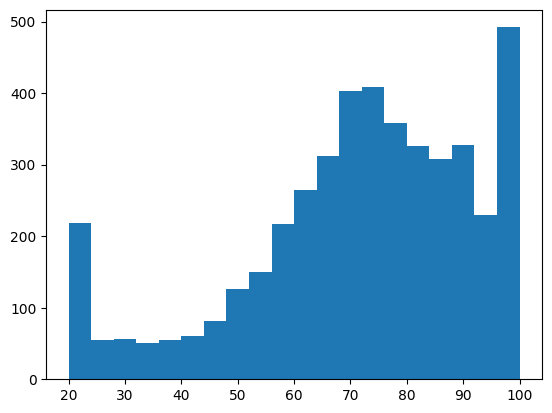

In [59]:
_ = plt.hist([xy['original_score'] for xy in sts_training_dicts], bins=20)

The data seems 'unbalanced', with text pairs that are more similar than dissimilar.

As we have multiple responses per text pair (in the field 'sampled_scores'), we can gain some information about the shape of the conditional distributions. Let's check the first few instances in the training data.

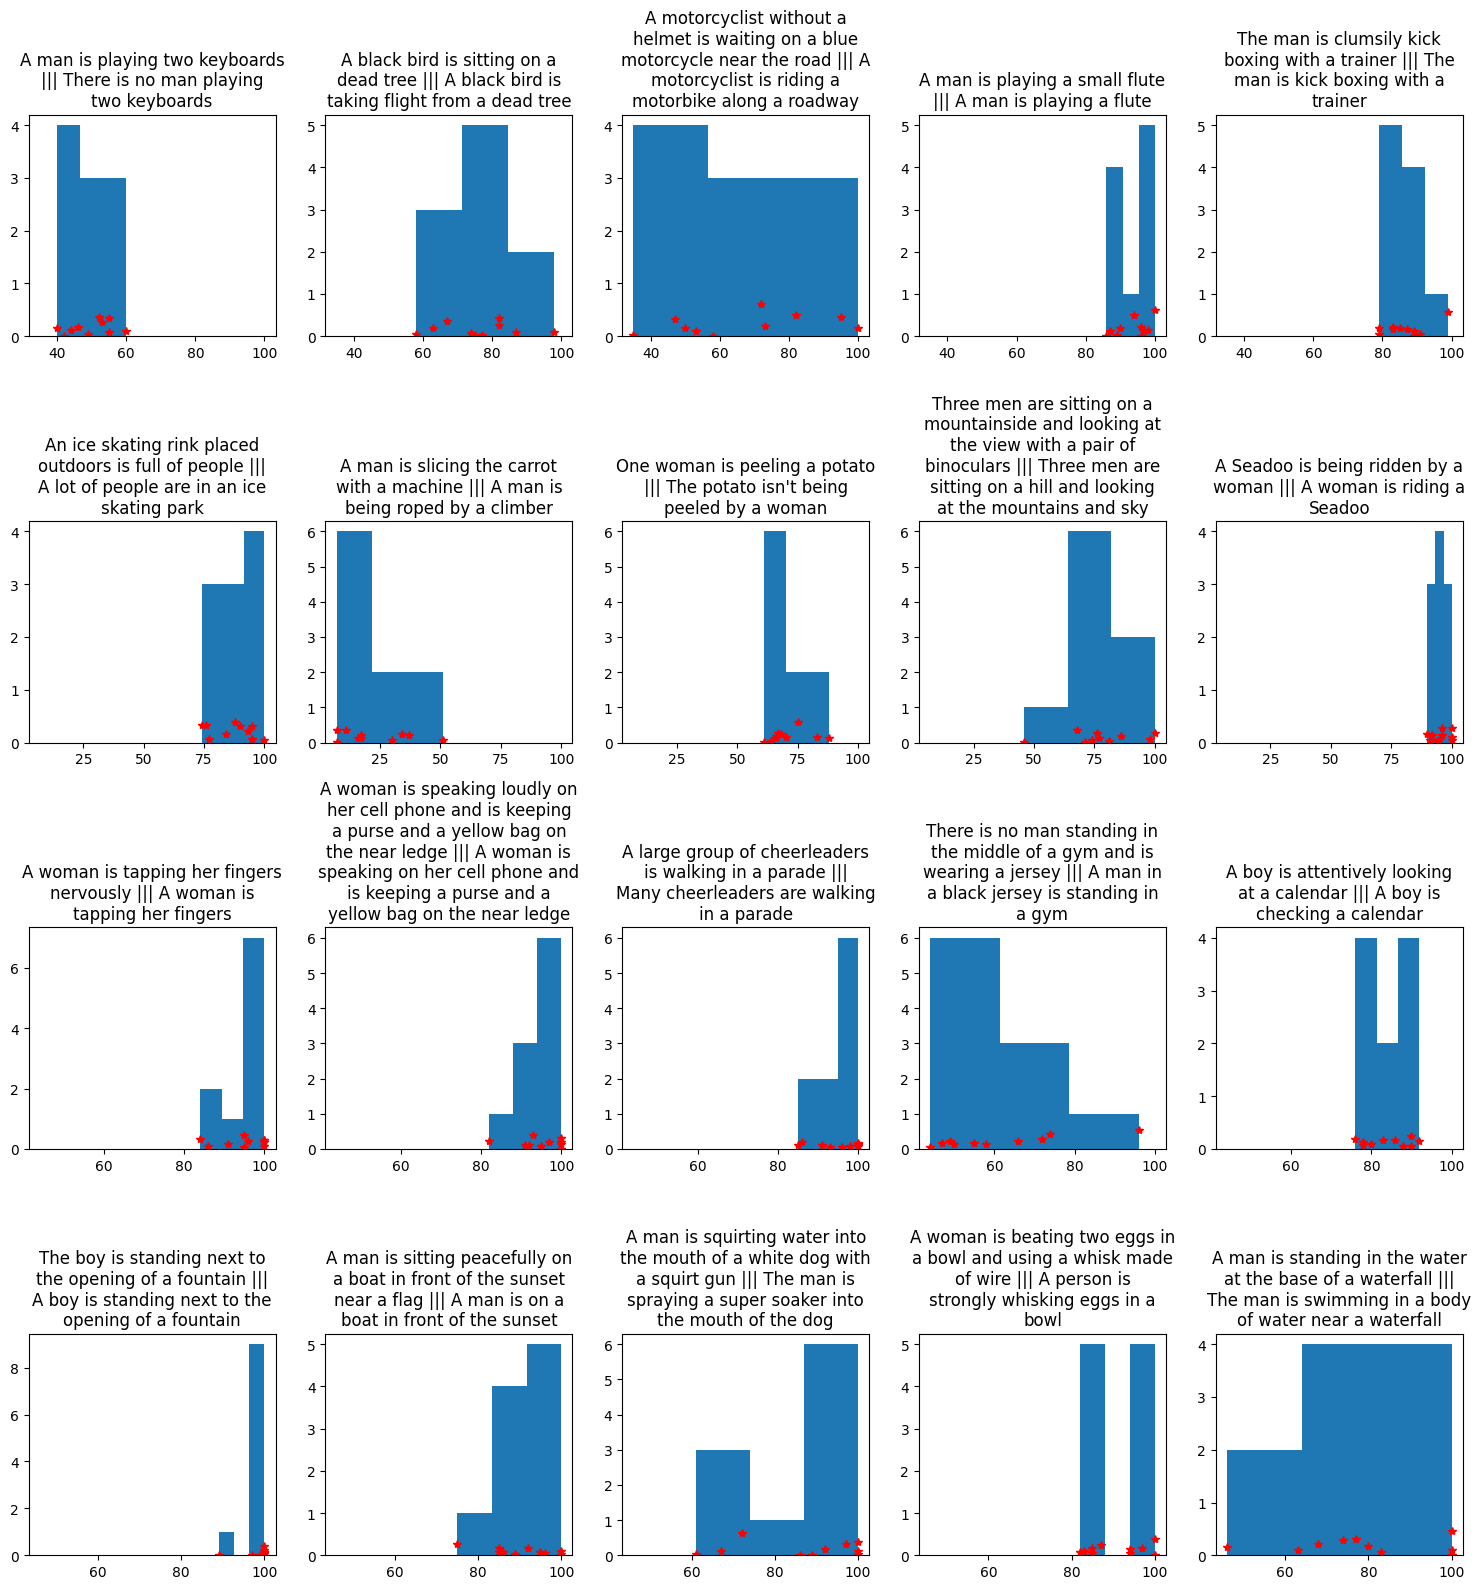

In [60]:
fig, axs = plt.subplots(4,5, sharex='row', figsize=(15,16))
for i, xy in enumerate(sts_training_dicts[:20]):
    _ = axs[i//5,i%5].set_title("\n".join(textwrap.wrap(f"{xy['a']} ||| {xy['b']}", 30)))
    _ = axs[i//5,i%5].hist(xy['sampled_scores'], bins=3)
    _ = axs[i//5,i%5].plot(xy['sampled_scores'], np.abs(np.random.normal(0, 0.2, size=len(xy['sampled_scores']))), '*', color='red')
fig.tight_layout(w_pad=1, h_pad=1)

From the shapes of these distributions and the fact that the data is ordinal and discrete (integer) we need to choose a pmf that exhibit a mode that can be parameterised away from 0 (this excludes the Geometric). As the support is finite (0-100) we could consider the Binomial, but, for this exercise, we will instead use the *Poisson*.

Our choice is mostly didatic, we pick the Poisson because ordinal regression (which this is an example of) is *often* performed with a Poisson.

Let's now prepare the data for JAX.

For this task we will use training triples made of $x=(a,b)$ and $y$ will be the field 'original_score'.

In [61]:
sts_training = []
for xy in sts_training_dicts:
    sts_training.append((xy['a'], xy['b'], xy['original_score']))

# This is what a data point looks like
print("We haven {len(sts_training)} training triples, example:\n", sts_training[0])

We haven {len(sts_training)} training triples, example:
 ('A man is playing two keyboards', 'There is no man playing two keyboards', 48)


We now repeat this for the dev set:

In [62]:
sts_dev_dicts = json.load(urllib.request.urlopen("https://raw.githubusercontent.com/probabll/ntmi-tutorials/main/datasets/SICK_test.1.json"))
sts_dev = []
for xy in sts_dev_dicts:
    for y in xy['sampled_scores']: # for dev and test we will use all the sampled scores (this is so we can see variability in human ratings)
        sts_dev.append((xy['a'], xy['b'], y))
print(f"We have {len(sts_dev)} dev triples, example:\n", sts_dev[0])

We have 24640 dev triples, example:
 ('A dog, which is brown, and a black one are racing in the grass', 'A dark black dog and a light brown dog are playing in the backyard', 41)


And let's also prepare the test set:

In [63]:
sts_test_dicts = json.load(urllib.request.urlopen("https://raw.githubusercontent.com/probabll/ntmi-tutorials/main/datasets/SICK_test.2.json"))
sts_test = []
for xy in sts_test_dicts:
    for y in xy['sampled_scores']:
        sts_test.append((xy['a'], xy['b'], y))

print(f"We have {len(sts_test)} test triples, example:\n", sts_test[0])

We have 24630 test triples, example:
 ('There is no team playing soccer', 'Two teams are playing soccer', 58)


### Feature function

Our feature function will be very simple, we will compute $\mathbf h(x) = |\mathrm{bow}(a) - \mathrm{bow}(b)|$. That is, the absolute difference between the bag-of-words encoding of the two sentences.

For that, we start with a bag-of-words encoding. The CountVectorizer is a very efficient way to obtain those:

In [64]:
bow_ff = Pipeline(
    [
        ('vect', CountVectorizer(ngram_range=(1,1), min_df=3)),
    ]
)

# we train it on the concatenation of all sentences in the training data
bow_ff.fit([xy[0] for xy in sts_training] + [xy[1] for xy in sts_training])

Pipeline(steps=[('vect', CountVectorizer(min_df=3))])

And now we can compute our actual feature function as defined previously:

In [65]:
# Remember, x is a pair of sentences (a, b)

# encode part a of x
training_ha = bow_ff.transform([xy[0] for xy in sts_training])
# encode part b of x
training_hb = bow_ff.transform([xy[1] for xy in sts_training])
# encode x as |bow(a)-bow(b)|
training_h = np.abs(training_ha-training_hb)
# grab the responses
training_y = np.array([xy[2] for xy in sts_training])

# do the same for dev set
# encode a
dev_ha = bow_ff.transform([xy[0] for xy in sts_dev])
# encode b
dev_hb = bow_ff.transform([xy[1] for xy in sts_dev])
# compute absolute difference
dev_h = np.abs(dev_ha-dev_hb)
# grab responses
dev_y = np.array([xy[2] for xy in sts_dev])

<a name='graded-2'> **Graded Exercise 2 - Poisson regression** </a>

You will now design a Poisson GLM. There are striking similarities with the Bernoulli GLM, and our class structure emphasises that, but be careful to implement a **Poisson** regressor here, and not just another Bernoulli model.

1. Complete the PoissonRegressor class below, it only lacks implementation for two methods, namely, `activation` and `log_p`. To help you get this right, we have coded a few test cases that your implementation should pass.
    
2. Once you have it, train the model for at least 40 epochs (more is also fine) with regularisation (use 1e-4). As always, plot the information logged during training. Finally, report performance on the test set (in terms of mean absolute error).
    
3. For your trained model, inspect the features that received higher positive weight and higher negative weight. See if you can find clear cases of word pairs that likely drag similarity up or down for their semantic content is same/different.

4. Use your model to predict Poisson distributions for at least the first 16 data points in the dev set. For each data point, plot a histogram of samples from the Poisson distribution predicted by the model, also plot the observed values for $y$ that are recorded in the data set (use red crosses as we did in the beginning of the section). Remember that once you've obtained the Poisson parameter from your GLM, you can use `np.random.poisson` to obtain samples, for example.
    
5. Using the plotting technique above, find 5 examples where the trained model does not perform well (the observations are far from the predictions). Explain why you interepret these examples as failures. Finally, speculate about what might have caused the problem (e.g., do you think it's a problem with the feature function, or is it a problem with the choice of distribution? explain your thoughts).

In [97]:
from sklearn.metrics import mean_absolute_error


class PoissonRegressor(GLM1):

    def __init__(self, feature_function, seed=0):
        super().__init__(feature_function, seed=seed)

    def activation(self, linear_predictor):
        """In Poisson regression we constrain the linear predictor to being strictly positive, which can be done with exp or softplus, for example"""
        return np.log1p(np.exp(linear_predictor))  # = softplus: log(1 + exp(x))

    def decide(self, g):
        """For the Poisson, let's decide using the mode, which is obtained via floor"""
        return jnp.floor(g)

    def log_p(self, targets, g):
        """
        We use JAX scipy to return the log pmf of the Poisson
        """
        return jax.scipy.stats.poisson.logpmf(targets, g)


    def validate(self, inputs, targets, *, w, b):
        y_pred = self.predict(inputs, w=w, b=b)
        return mean_absolute_error(targets, y_pred)

In [67]:
# CONTRIBUTE YOUR SOLUTION/CODE

Test cases for part 1:

In [68]:
poi_reg = PoissonRegressor(bow_ff)

In [69]:
assert jnp.all(poi_reg.activation(np.random.uniform(size=1000)) > 0.), "The Poisson parameter should be *strictly* positive (larger than 0)"

NotImplementedError: Implement me!

In [ ]:
test_case_targets = np.array([0, 1, 2, 3, 4])
test_case_rates = np.array([1., 1., 2., 2., 3.])
test_case_logpmf = np.array([-1.0000005, -1.       , -1.3068521, -1.7123183, -1.7836056])
assert jnp.allclose(poi_reg.log_p(test_case_targets, test_case_rates), test_case_logpmf, 1e-3), "Did you implement the correct expression for Poisson's log pmf? You can use JAX scipy code for that, rather than write it from scratch."

Helper code for part 2:

In [ ]:
# This should take a couple of minutes (the progress bar should give you a reliable estimate)
# for a faster run reduce num_epochs or increase batch_size
# of course, do expect changes in performance
# you can use lr0 and l2weight to affect the optimiser and the objective function
(poi_w, poi_b), poi_log = train_model(
    poi_reg,
    training_h,
    training_y,
    dev_h,
    dev_y,
    lr0=5.,
    l2weight=1e-4, # larger means more regularisation
    batch_size=100, # use more for faster training (if you are on GPU, this can be bigger)
    num_epochs=30, # use more to find better models
    rng=np.random.RandomState(42),
)

In [ ]:
# CONTRIBUTE YOUR SOLUTION/CODE

	CONTRIBUTE YOUR SOLUTION/DISCUSSION

---

<a name='ungraded-6'></a> **Ungraded Exercise 6 - Further analysis**

The code below can be useful for some (optional) further analysis. We compute the proportion of red stars (observations) that fall within the blue curve (model samples) and vice versa. This gives us another notion of quality.

Another way to visualise the results is a scatter of the lower (or upper) observation vs the lower (or upper) model sample. Ideally these quantities correlate perfectly. The more linear and diagonal the scatter looks, the better.

In [ ]:
def compare_models(data_dicts, models):
    """
    For a collection of models, plot
        * proportion of model samples that fall within data samples
        * proportion of data samples that fall within model sampels
        * scatter plot of data sampels vs model samples

    data_dicts: list of data points (each a dict)
    models: list of 4-tuples, each tuple is
        (poisson regressor, trained weights, trained bias, a string label to display in plots)
    """


    fig, ax = plt.subplots(len(models), 3, sharey='col', sharex='col', figsize=(16, 4 * len(models)))
    if len(models) == 1:
        ax = ax[None,:]

    for j, (reg, weights, bias, name) in enumerate(models):

        pred_in_obs = []
        obs_in_pred = []
        lower = []
        upper = []

        for i, xy in enumerate(data_dicts):
            a, b, ys = xy['a'], xy['b'], xy['sampled_scores']
            h = np.abs(reg.feature_function.transform([a]) - reg.feature_function.transform([b]))
            rate = reg.g(h.toarray(), w=weights, b=bias).item()
            # 90% central interval
            preds = np.random.poisson(rate, size=100)
            central = sorted(preds)[5:95]
            sortedys = sorted(ys)
            pred_in_obs.append(sum(sortedys[0] <= y <= sortedys[-1] for y in preds) / len(preds))
            obs_in_pred.append(sum(central[0] <= y <= central[-1] for y in ys) / len(ys))
            lower.append([sortedys[0], central[0]])
            upper.append([sortedys[-1], central[-1]])

        _ = ax[j,0].hist(pred_in_obs, bins=10)
        _ = ax[j,0].set_xlabel("proportion of pred y within obs")
        _ = ax[j,1].hist(obs_in_pred, bins=10)
        _ = ax[j,1].set_xlabel("proportion of obs y within 90% central preds")
        _ = ax[j,0].set_ylabel(f"{name}")

        _ = ax[j, 2].scatter([pair[0] for pair in lower], [pair[1] for pair in lower], alpha=0.4, marker='<', label='lower')
        _ = ax[j, 2].scatter([pair[0] for pair in upper], [pair[1] for pair in upper], alpha=0.6, marker='>', label='upper')
        _ = ax[j, 2].plot(np.linspace(0, 100, 20), np.linspace(0, 100, 20), color='black', linestyle='--', label='ideal')
        _ = ax[j, 2].set_xlabel("observations", fontsize=14)
        _ = ax[j, 2].set_ylabel("samples", fontsize=14)
        _ = ax[j, 2].set_xticks(ax[j, 2].get_xticks())
        _ = ax[j, 2].set_yticks(ax[j, 2].get_yticks())
        _ = ax[j, 2].legend(fontsize=14)

    fig.suptitle("Comparison: model and data overlap")
    plt.show()

    fig.tight_layout(h_pad=1, w_pad=1)


In [ ]:
# For example, we can train various models (using different amount of data) and compare them
trained_models = []

for pct in [0.05, 0.1, 0.2, 0.5]:
    reg = PoissonRegressor(bow_ff)
    # This should take a couple of minutes (the progress bar should give you a reliable estimate)
    # for a faster run reduce num_epochs or increase batch_size
    # of course, do expect changes in performance
    # you can use lr0 and l2weight to affect the optimiser and the objective function
    (reg_w, reg_b), reg_log = train_model(
        reg,
        training_h[:int(len(sts_training) * pct)],
        training_y[:int(len(sts_training) * pct)],
        dev_h,
        dev_y,
        lr0=5.,
        l2weight=1e-4, # larger means more regularisation
        batch_size=100, # use more for faster training (if you are on GPU, this can be bigger)
        num_epochs=20, # use more to find better models
        rng=np.random.RandomState(42),
    )
    trained_models.append((reg, reg_w, reg_b, f"{pct*100}% data"))

In [ ]:
compare_models(
    sts_dev_dicts,
    trained_models
)